In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [2]:
data = list()

for i, subfolder in enumerate(os.listdir("data")):
    subfolder_path = os.path.join("data", subfolder)

    for filename in os.listdir(subfolder_path):
        file_path = os.path.join(subfolder_path, filename)
        file_data = pd.read_csv(file_path)

        if i == 0:
            file_data["activity"] = "idle"
        elif i == 1:
            file_data["activity"] = "running"
        elif i == 2:
            file_data["activity"] = "stairs"
        elif i == 3:
            file_data["activity"] = "walking"

        data.append(file_data)

df = pd.concat(data, ignore_index=True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193860 entries, 0 to 193859
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   activity         193860 non-null  object 
dtypes: float64(3), object(1)
memory usage: 5.9+ MB


,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,1.000776,4.616021,8.576031,idle
1,0.718261,4.209007,8.446744,idle
2,-0.909797,-0.282516,9.203311,idle
3,5.099650,0.148441,8.418014,idle
4,1.762132,-0.162806,9.251195,idle
...,...,...,...,...
193855,5.109226,-15.452178,-1.470040,walking
193856,6.373365,-11.741165,-8.226476,walking
193857,3.289633,-9.993398,-0.383072,walking
193858,-2.978387,-3.050213,1.273715,walking


<Axes: xlabel='activity', ylabel='count'>

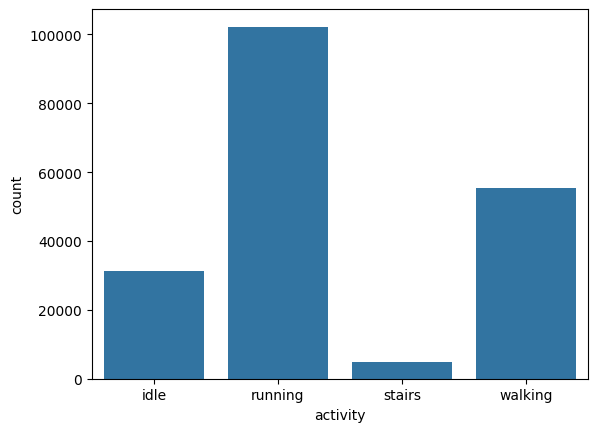

In [3]:
sns.countplot(x="activity", data=df)

In [4]:
df = shuffle(df, random_state=42)
label = LabelEncoder()
df["activity"] = label.fit_transform(df["activity"])
y = df["activity"]
df.drop(["activity"], axis="columns", inplace=True)

In [5]:
num_cols = df.dtypes[df.dtypes == "float64"].index.values
df[num_cols].describe()

,accelerometer_X,accelerometer_Y,accelerometer_Z
count,193860.000000,193860.000000,193860.000000
mean,1.923550,1.598343,1.804896
std,8.404867,12.474041,7.191590
min,-39.188293,-39.188293,-39.188293
25%,-2.494758,-8.327033,-2.494758
50%,0.248997,-0.009577,0.905008
75%,4.668694,8.671799,7.187394
max,39.188293,39.188293,39.188293


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, stratify=y, random_state=42
)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
    ]
)

In [7]:
models = {
    "SVC": {
        "model": SVC(probability=True, random_state=42),
        "params": {"classifier__C": [0.1, 1, 10]},
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "params": {
            "classifier__n_estimators": [10, 50],
            "classifier__max_depth": [10, 20],
            "classifier__min_samples_split": [2, 5],
            "classifier__min_samples_leaf": [1, 2],
        },
    },
}

results = {}

In [8]:
for name, model_info in models.items():
    pipeline = Pipeline(
        [("preprocessor", preprocessor), ("classifier", model_info["model"])]
    )

    grid_search = GridSearchCV(pipeline, model_info["params"], cv=3)
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    classification_rep = classification_report(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    results[name] = {
        "model": grid_search,
        "classification_report": classification_rep,
        "confusion_matrix": confusion_mat,
    }

Модель: SVC
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7793
           1       0.93      0.91      0.92     25560
           2       0.84      0.01      0.03      1237
           3       0.81      0.90      0.85     13875

    accuracy                           0.90     48465
   macro avg       0.89      0.70      0.69     48465
weighted avg       0.90      0.90      0.89     48465

Найкращі параметри:
{'classifier__C': 10}




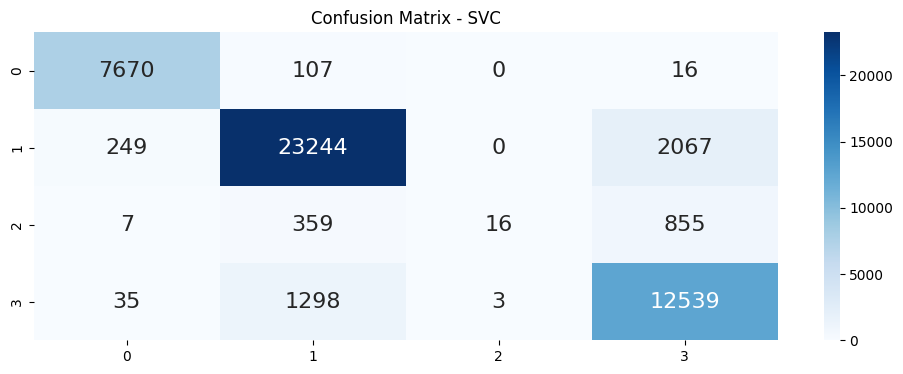

Модель: RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7793
           1       1.00      1.00      1.00     25560
           2       1.00      0.96      0.98      1237
           3       1.00      1.00      1.00     13875

    accuracy                           1.00     48465
   macro avg       1.00      0.99      0.99     48465
weighted avg       1.00      1.00      1.00     48465

Найкращі параметри:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}




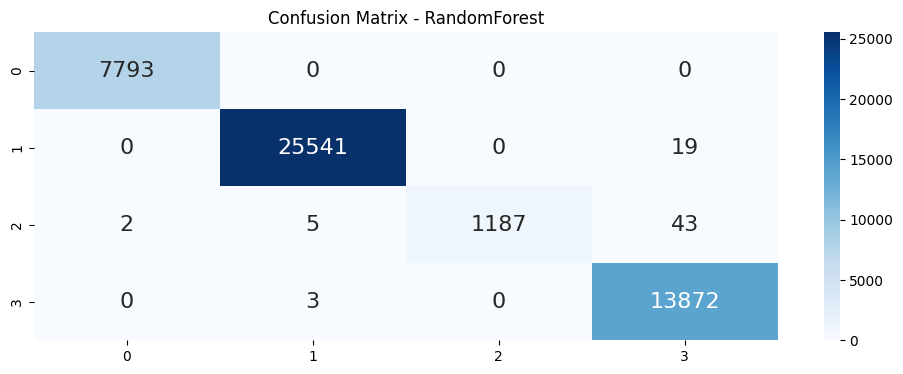

In [9]:
for name, result in results.items():
    print(f"Модель: {name}")
    print(result["classification_report"])
    print("Найкращі параметри:")
    print(result["model"].best_params_)
    print("\n")

    plt.figure(figsize=(12, 4))
    sns.heatmap(
        result["confusion_matrix"],
        annot=True,
        fmt="d",
        cmap="Blues",
        annot_kws={"size": 16},
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.show()